### First we will find the best learning rate for one cycle, as proposed in the original paper

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.chdir("../models")

import pickle
import torch
import torch.nn as nn
import torchvision

from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, test_model
from datetime import datetime
from model import DepthPointWiseCNN
from sklearn.metrics import top_k_accuracy_score, f1_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

model_name = "OneCycleLRTest"
model_seed = 42
batchnorm_moment = 0.05

# set seed
set_seed(model_seed)

device_type = None
device = None
# determine device type
if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
    device_type = "cuda"
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
    device_type = "mps"
else:
    device = torch.device("cpu")
    device_type = "mps"

device_type

'cuda'

### Initialise model

In [2]:
model = DepthPointWiseCNN(batchnorm_moment=batchnorm_moment).to(device_type) # initialise model
data_dir_path = "../data"

# Make directory to save baseline model
# Don't overwrite exisiting models and model outputs
model_path = f"./saved_models/{model_name}/"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
else:
    raise Exception('''
        Directory already exists. Either choose a different 'model_name' or
        delete the exisiting directory.
    ''')

# Construct the full path
device_path = os.path.join(model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

### Initialise Dataset

In [3]:
data_path = "../data"

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100), antialias=True),
])

# load data
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped
train_dataset = datasets.Flowers102(root=data_path,
                                    split='test',
                                    download=True,
                                    transform=transform
                                   ) 
val_dataset = datasets.Flowers102(root=data_path,
                                  split='val',
                                  download=True,
                                  transform=transform
                                 )

# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
val_dataset

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ../data
    split=val
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
           )

### Specify hyperparameters
#### The loss will be incremented for every minibatch, untill it explodes.

In [11]:
class AdamWrapper(torch.optim.Adam):
    def __init__(self, lr_step, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.init_lr = kwargs["lr"]
        self.lr_step = lr_step

    def step(self, *args, **kwargs):
        for g in self.param_groups:
            g['lr'] = self.init_lr

        super().step(*args, **kwargs)
        self.init_lr += self.lr_step
    
lr = 0.0001 # learning rate
lr_step = lr / 50
optimiser = AdamWrapper(lr_step, model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function
epochs = 100
patience = 10

early_stopper = EarlyStopper(patience=patience) # initialise early stopper

### Train the model

In [12]:
out = train(model, train_dataloader, val_dataloader, optimiser,
            loss, device, epochs, early_stopper, device_path
           )
train_loss_list, val_loss_list, val_acc_list, train_time_list, lr_list, early_stop = out

Epoch 1/100: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, Training loss=0.4796, Learning rate=0.00020]


Epoch 1/100 took 31.32s | Train loss: 0.4796 | Val loss: 1.5943 | Val accuracy: 59.12% | EarlyStopper count: 0


Epoch 2/100: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, Training loss=0.3033, Learning rate=0.00029]


Epoch 2/100 took 31.40s | Train loss: 0.3033 | Val loss: 1.5752 | Val accuracy: 60.69% | EarlyStopper count: 0


Epoch 3/100: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, Training loss=0.2615, Learning rate=0.00039]


Epoch 3/100 took 31.27s | Train loss: 0.2615 | Val loss: 1.5436 | Val accuracy: 61.67% | EarlyStopper count: 0


Epoch 4/100: 100%|██████████| 49/49 [00:26<00:00,  1.83it/s, Training loss=0.2066, Learning rate=0.00049]


Epoch 4/100 took 30.64s | Train loss: 0.2066 | Val loss: 1.5509 | Val accuracy: 60.10% | EarlyStopper count: 0


Epoch 5/100: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, Training loss=0.1965, Learning rate=0.00059]


Epoch 5/100 took 31.42s | Train loss: 0.1965 | Val loss: 1.5493 | Val accuracy: 62.16% | EarlyStopper count: 1


Epoch 6/100: 100%|██████████| 49/49 [00:26<00:00,  1.82it/s, Training loss=0.1732, Learning rate=0.00069]


Epoch 6/100 took 30.84s | Train loss: 0.1732 | Val loss: 1.5641 | Val accuracy: 62.35% | EarlyStopper count: 2


Epoch 7/100: 100%|██████████| 49/49 [00:26<00:00,  1.84it/s, Training loss=0.1576, Learning rate=0.00078]


Epoch 7/100 took 30.55s | Train loss: 0.1576 | Val loss: 1.5948 | Val accuracy: 60.29% | EarlyStopper count: 3


Epoch 8/100: 100%|██████████| 49/49 [00:26<00:00,  1.82it/s, Training loss=0.1351, Learning rate=0.00088]


Epoch 8/100 took 30.86s | Train loss: 0.1351 | Val loss: 1.5745 | Val accuracy: 61.47% | EarlyStopper count: 4


Epoch 9/100: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, Training loss=0.1351, Learning rate=0.00098]


Epoch 9/100 took 31.13s | Train loss: 0.1351 | Val loss: 1.5888 | Val accuracy: 61.76% | EarlyStopper count: 5


Epoch 10/100: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, Training loss=0.1283, Learning rate=0.00108]


Epoch 10/100 took 31.03s | Train loss: 0.1283 | Val loss: 1.5902 | Val accuracy: 62.65% | EarlyStopper count: 6


Epoch 11/100: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, Training loss=0.1352, Learning rate=0.00118]


Epoch 11/100 took 30.82s | Train loss: 0.1352 | Val loss: 1.6448 | Val accuracy: 60.29% | EarlyStopper count: 7


Epoch 12/100: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, Training loss=0.0985, Learning rate=0.00127]


Epoch 12/100 took 31.32s | Train loss: 0.0985 | Val loss: 1.6496 | Val accuracy: 59.61% | EarlyStopper count: 8


Epoch 13/100: 100%|██████████| 49/49 [00:26<00:00,  1.83it/s, Training loss=0.4049, Learning rate=0.00137]


Epoch 13/100 took 30.49s | Train loss: 0.4049 | Val loss: 2.3810 | Val accuracy: 54.51% | EarlyStopper count: 9
Early stopping


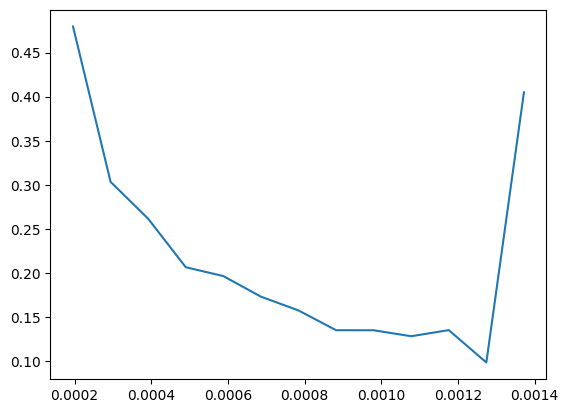

In [13]:
import matplotlib.pyplot as plt

plt.plot(lr_list, train_loss_list)

### The best is around 0.001, we will take 0.001 as the max and 0.001 / 10 as the minimum for the one cycle policy

In [17]:
data = {
    "time_trained": datetime.now().strftime("%D,%H:%M:%S"),
    "model_name": model_name,
    "model_seed": model_seed,
    "device_type": device_type,
    
    "batch_size": batch_size,
    "transform": transform,
    
    "lr": lr,
    "epochs": epochs,
    "patience": patience,
    
    "train_loss_list": train_loss_list,
    "val_loss_list": val_loss_list,
    "val_acc_list": val_acc_list,
    "train_time_list": train_time_list,
    "early_stop": early_stop,   # Boolean for if early stopping happened
    "lr_list": lr_list
}

with open(os.path.join(model_path, "data.pickle"), "wb") as f: 
    pickle.dump(data, f)